In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling2D, Concatenate, Softmax, Reshape
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import cv2
import moviepy.editor as mp
import os
import matplotlib.pyplot as plt
import random
import json
from sklearn.model_selection import train_test_split


In [2]:
# Audio Encoder
# 1. Prétraitement de l'audio
# max_length : longueur maximale des MFCCs, correspond à 2 secondes d'audio
def preprocess_audio(video, n_mfcc=40, max_length=173):
    """Split the audio from the video, extract the MFCCs and pad them to max_length"""
    # Charger l'audio
    audio = video.audio
    # Si l'audio est trop court, le remplir avec du silence
    if audio.duration < 2:
        audio = audio.set_duration(2)
    # Si l'audio est plus long que 2 secondes, ne garder que les 2 premières secondes
    else:
        audio = audio.subclip(0, 2)
    # Manipulation temporaire pour sauvegarder l'audio en .wav, obligatoire pour pouvoir charger avec librosa et extraire les MFCCs
    audio.write_audiofile("temp_audio.wav", logger=None)
    y, sr = librosa.load("temp_audio.wav")
    os.remove("temp_audio.wav")
    # Extraire les MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Transposer pour avoir la forme (timesteps, features)
    mfccs = mfccs.T
    # Troncature ou padding pour uniformiser la longueur
    if mfccs.shape[0] > max_length:
        mfccs = mfccs[:max_length, :]
    else:
        padding = max_length - mfccs.shape[0]
        mfccs = np.pad(mfccs, ((0, padding), (0, 0)), mode='constant')
    return mfccs
    # La sortie doit être de forme (None, timesteps, features)
    # return mfccs[np.newaxis, ...]

def AudioEncoder(input_shape=(173,40), encoded_dim=128):
    """
    Modèle d'encodage audio avec un LSTM.
    Arguments:
    - input_shape : forme de l'entrée audio (timesteps, features) ou (features).
    - encoded_dim : dimensions du vecteur encodé.
    """
    inputs = Input(shape=input_shape)

    # Adapter les dimensions si l'entrée est 2D (batch_size, features)
    if len(input_shape) == 1:
        reshaped = Reshape((1, input_shape[0]))(inputs)  # (batch_size, 1, features)
    else:
        reshaped = inputs

    # LSTM pour encoder
    x = LSTM(64, return_sequences=True)(reshaped)
    x = LSTM(64)(x)
    encoded = Dense(encoded_dim, activation='relu')(x)

    # Modèle
    return Model(inputs, encoded, name="AudioEncoder")


In [3]:
# Video Encoder
# 1. Prétraitement des frames
def preprocess_frame(video, target_size=(224, 224)):
    """Split the video to only keep the frame after 1sec and return it as an object variable"""
    # If the file is too short, only keep the first frame
    if video.duration < 1:
        frame = video.get_frame(0)
    else:
        # Only keep the frame after 1 second
        frame = video.get_frame(1)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert it to the right color space
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Redimensionner l'image
    frame = cv2.resize(frame, target_size)
    # Normalisation pour ResNet
    frame = tf.keras.applications.resnet.preprocess_input(frame)
    return frame
    # La sortie doit être de forme (None, height, width, channels)
    # Il faut donc ajouter une dimension pour le batch (None)
    # return np.array(frames)[np.newaxis, ...]

# 2. Création du modèle ResNet pour l'encodage
def VideoEncoder(input_shape=(224, 224, 3), encoded_dim=128):
    """Load a ResNet50 model with a GlobalAveragePooling layer and a Dense layer for encoding a frame"""

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Geler les poids du modèle pré-entraîné
    
    # Ajouter des couches pour obtenir un vecteur encodé
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(encoded_dim, activation='relu')(x)
    
    # Construire le modèle
    model = Model(inputs=base_model.input, outputs=x, name="VideoEncoder")
    return model

In [4]:
# MLP encoder
# 1. Création du MLP Encoder
def MLPEncoder(audio_dim=128, frame_dim=128, output_dim=128):
    # Entrée pour le vecteur audio
    audio_input = Input(shape=(audio_dim,), name="audio_input")
    audio_dense = Dense(64, activation="relu")(audio_input)

    # Entrée pour le vecteur video
    frame_input = Input(shape=(frame_dim,), name="frame_input")
    frames_dense = Dense(256, activation="relu")(frame_input)

    # Fusionner les deux entrées
    merged = Concatenate()([audio_dense, frames_dense])  # Fusionner (64 + 256 = 320)

    # Passages dans des couches MLP pour obtenir le vecteur utilisateur
    x = Dense(256, activation="relu")(merged)
    x = Dense(128, activation="relu")(x)
    user_vector = Dense(output_dim, activation="relu", name="user_vector")(x)

    # Modèle
    model = Model(inputs=[audio_input, frame_input], outputs=user_vector, name="MLPEncoder")
    return model

In [5]:
# Caracterizer (reliant les 3 modèles AudioEncoder, VideoEncoder et MLPEncoder)
def Caracterizer(audio_input_shape=(173,40), audio_encoded_dim=128, frame_input_shape=(224, 224, 3), frame_encoded_dim=128, user_encoded_dim=128):
    # Entrées
    # audio input shape: (None, 173, 40)
    audio_input = Input(shape=audio_input_shape, name="audio_input")
    # frames input shape: (None, 224, 224, 3)
    frame_input = Input(shape=frame_input_shape, name="frame_input")

    # définir les encodeurs
    audio_encoder = AudioEncoder(input_shape=audio_input_shape, encoded_dim=audio_encoded_dim)
    video_encoder = VideoEncoder(input_shape=frame_input_shape, encoded_dim=frame_encoded_dim)
    mlp_encoder = MLPEncoder(audio_dim=audio_encoded_dim, frame_dim=frame_encoded_dim, output_dim=user_encoded_dim)

    # audio_vector = audio_encoder.predict(mfccs)
    # frame_vector = video_encoder.predict(frame)
    # user_vector = mlp_encoder.predict([audio_vector, frame_vector])

    # Lier les encodeurs ensemble
    audio_vector = audio_encoder(audio_input)
    # print('audio_vector shape:', audio_vector.shape)
    # # frames_input shape: (None, 224, 224, 3)
    frame_vector = video_encoder(frame_input)
    # print('frame_vector shape:', frame_vector.shape)
    # # Utilisez une couche Lambda pour empiler les tensors le long de la dimension des frames
    # frames_encoded = Lambda(lambda x: tf.stack(x, axis=1), name="frames_concatenation")(frames_encoded_list)
    # # ajouter une dimension batch au début afin d'avoir la forme (None, 60, 128)
    # frames_encoded = Reshape((num_frames, frame_dim))(frames_encoded)
    
    # MLP Encoder input shape: None, 60, 128
    user_vector = mlp_encoder([audio_vector, frame_vector])

    # Modèle final
    model = Model(inputs=[audio_input, frame_input], outputs=user_vector, name="Caracterizer")
    return model

In [6]:
# MLP Decoder
def MLPDecoder(input_dim=128, num_users=10):
    """
    Crée un modèle MLP Decoder prenant en entrée un vecteur utilisateur (user_vector)
    et renvoyant la probabilité d'appartenance à un utilisateur via une couche softmax.
    
    Arguments :
    - input_dim : Dimension du vecteur utilisateur en entrée.
    - num_users : Nombre maximal d'utilisateurs (#usersmax).
    
    Retour :
    - Modèle Keras du MLP Decoder.
    """
    # Entrée : vecteur utilisateur
    user_vector_input = Input(shape=(input_dim,), name="user_vector_input")
    
    # Couches Dense avec activations ReLU
    x = Dense(128, activation="relu")(user_vector_input)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(num_users, activation="relu")(x)  # Dernière couche dense
    
    # Couche Softmax pour obtenir les probabilités
    output = Softmax(name="user_probabilities")(x)
    
    # Modèle
    model = Model(inputs=user_vector_input, outputs=output, name="Decoder")
    return model


In [7]:
# Création du modèle complet
def CompleteModel(audio_input_shape=(173,40), audio_encoded_dim=128, frame_input_shape=(224, 224, 3), frame_encoded_dim=128, user_encoded_dim=128, num_users=10):
    # Créer les modèles
    caracterizer = Caracterizer(audio_input_shape=audio_input_shape, audio_encoded_dim=audio_encoded_dim, frame_input_shape=frame_input_shape, frame_encoded_dim=frame_encoded_dim, user_encoded_dim=user_encoded_dim)
    mlp_decoder = MLPDecoder(input_dim=user_encoded_dim, num_users=num_users)
    
    # Entrées
    audio_input = Input(shape=audio_input_shape, name="audio_input")
    frame_input = Input(shape=frame_input_shape, name="frame_input")
    
    # Caractérisation
    user_vector = caracterizer([audio_input, frame_input])
    
    # Décodage
    user_probabilities = mlp_decoder(user_vector)
    
    # Modèle complet
    model = Model(inputs=[audio_input, frame_input], outputs=user_probabilities)
    return model

In [8]:
# # Exemple d'utilisation pour les modèles séparés (l'audio + la vidéo + le MLP Encoder + le MLP Decoder)
# # Dataloader
# video_path = 'data/Yann_Zurbrugg/WhatsApp Video 2024-12-02 at 11.41.31.mp4'
# # Charger la vidéo
# video = mp.VideoFileClip(video_path)
    
# # Prétraiter le fichier audio
# mfccs = preprocess_audio(video)
# mfccs = np.expand_dims(mfccs, axis=0)  # Ajouter une dimension batch
# # Prétraiter la vidéo
# frame = preprocess_frame(video)
# frame = np.expand_dims(frame, axis=0)  # Ajouter une dimension batch

# # Créer le modèle
# audio_encoder = AudioEncoder(input_shape=(173,40), encoded_dim=128)
# video_encoder = VideoEncoder(input_shape=(224, 224, 3), encoded_dim=128)
# mlp_encoder = MLPEncoder(audio_dim=128, frame_dim=128, output_dim=128)
# num_users = 5  # Nombre maximal d'utilisateurs
# decoder = MLPDecoder(input_dim=128, num_users=num_users)

# # Résumer les modèles
# audio_encoder.summary()
# video_encoder.summary()
# mlp_encoder.summary()
# decoder.summary()

# # Passer les données dans le modèle
# audio_vector = audio_encoder.predict(mfccs)
# frame_vector = video_encoder.predict(frame)
# user_vector = mlp_encoder.predict([audio_vector, frame_vector])
# user_probabilities = decoder.predict(user_vector)

# print("Forme du vecteur audio encodé:", audio_vector.shape)  # (1, 128)
# print("Forme du vecteur vidéo encodé :", frame_vector.shape)  # (60, 128)
# print("Forme du vecteur utilisateur :", user_vector.shape)  # (1, 128)
# # Prédire les probabilités pour chaque utilisateur
# print("Probabilités utilisateur :", user_probabilities)

Dictionnaire user_to_id: {'Jean_Bon': 0, 'Yann_Zurbrugg': 1}
Dictionnaire id_to_user: {0: 'Jean_Bon', 1: 'Yann_Zurbrugg'}
Utilisateur 0 (Jean_Bon): 4 vidéos chargées
Utilisateur 1 (Yann_Zurbrugg): 12 vidéos chargées
Forme des données audio: (16, 173, 40)
Forme des données frame: (16, 224, 224, 3)
Forme des labels: (16,)


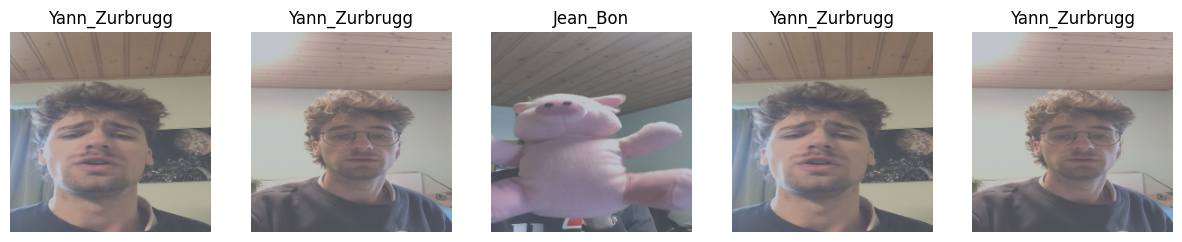

Forme des données audio d'entraînement: (14, 173, 40)
Forme des données frame d'entraînement: (14, 224, 224, 3)
Forme des labels d'entraînement: (14,)
Forme des données audio de test: (2, 173, 40)
Forme des données frame de test: (2, 224, 224, 3)
Forme des labels de test: (2,)


In [12]:
# Charger les données
data_path = 'data/'
# Charger les données, les noms des dossiers correspondent aux noms des utilisateurs
users = os.listdir(data_path)
# Créer un dictionnaire pour associer chaque utilisateur à un identifiant unique
user_to_id = {user: i for i, user in enumerate(users)}
print("Dictionnaire user_to_id:", user_to_id)
# Créer un dictionnaire inverse pour retrouver le nom de l'utilisateur à partir de l'identifiant
id_to_user = {i: user for user, i in user_to_id.items()}
print("Dictionnaire id_to_user:", id_to_user)
# Créer un tableau pour stocker les données
X_video = []
X_audio = []
X_frame = []
Y = []

# Charger les données
for user in users:
    user_id = user_to_id[user]
    user_path = os.path.join(data_path, user)
    # Charger les vidéos
    videos = os.listdir(user_path)
    for video_name in videos:
        video_path = os.path.join(user_path, video_name)
        video = mp.VideoFileClip(video_path)
        # Prétraiter l'audio
        mfccs = preprocess_audio(video)
        X_audio.append(mfccs)
        # Prétraiter la vidéo
        frame = preprocess_frame(video)
        X_frame.append(frame)
        # Ajouter l'identifiant de l'utilisateur
        Y.append(user_id)
        # Ajouter le nom de la vidéo
        X_video.append(video_name)
    print(f"Utilisateur {user_id} ({user}): {len(videos)} vidéos chargées")

# Afficher les formes des données
X_audio = np.array(X_audio)
X_frame = np.array(X_frame)
Y = np.array(Y)
print("Forme des données audio:", X_audio.shape)
print("Forme des données frame:", X_frame.shape)
print("Forme des labels:", Y.shape)

# Affiche 5 des frames avec les labels correspondants
plt.figure(figsize=(15, 5))
for i in range(5):
    index = random.randint(0, len(X_frame)-1)
    frame = X_frame[index]
    # adapter les valeurs pour matplotlib, actuellement entre -255 et 255
    frame = (frame + 255) / 2 / 255
    # Adapter le colorspace, actuellement tout est trop bleu
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    label = id_to_user[Y[index]]
    plt.subplot(1, 5, i+1)
    plt.imshow(frame)
    plt.title(label)
    plt.axis('off')
plt.show()

# Séparer les données en ensembles d'entraînement et de test
X_audio_train, X_audio_test, X_frame_train, X_frame_test, Y_train, Y_test = train_test_split(X_audio, X_frame, Y, test_size=0.1, random_state=42)
print("Forme des données audio d'entraînement:", X_audio_train.shape)
print("Forme des données frame d'entraînement:", X_frame_train.shape)
print("Forme des labels d'entraînement:", Y_train.shape)
print("Forme des données audio de test:", X_audio_test.shape)
print("Forme des données frame de test:", X_frame_test.shape)
print("Forme des labels de test:", Y_test.shape)

In [10]:
# Créer le modèle complet
model = CompleteModel(num_users=len(users))
# CompleteModel(audio_input_shape=(173,40), audio_encoded_dim=128, frame_input_shape=(224, 224, 3), frame_encoded_dim=128, user_encoded_dim=128, num_users=2)

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit([X_audio_train, X_frame_train], Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Évaluer le modèle
loss, accuracy = model.evaluate([X_audio_test, X_frame_test], Y_test)
print("Perte:", loss)
print("Précision:", accuracy)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9167 - loss: 0.6537 - val_accuracy: 0.5000 - val_loss: 0.7660
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.9167 - loss: 0.4478 - val_accuracy: 0.5000 - val_loss: 0.9318
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.9167 - loss: 0.2386 - val_accuracy: 0.5000 - val_loss: 1.2231
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.9167 - loss: 0.1340 - val_accuracy: 0.5000 - val_loss: 0.8514
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - accuracy: 0.9167 - loss: 0.0687 - val_accuracy: 0.5000 - val_loss: 0.3515
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 1.0000 - loss: 0.0600 - val_accuracy: 1.0000 - val_loss: 0.3475
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 1.0000 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.3471
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 1.0000 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 

In [11]:
# Sauvegarder le modèle dans un fichier 
model_path = 'weights and id/CompleteModel.keras'
model.save(model_path)

# Sauvegarder uniquement les poids du Caracterizer
caracterizer_path = 'weights and id/Caracterizer.keras'
caracterizer = model.get_layer("Caracterizer")
caracterizer.save(caracterizer_path)

# Sauvegarder uniquement les poids du Decoder
decoder_path = 'weights and id/Decoder.keras'
decoder = model.get_layer("Decoder")
decoder.save(decoder_path)

# Sauvegarder le dictionnaire id_to_user avec, dans un fichier JSON
dict_path = 'weights and id/id_to_user.json'
with open(dict_path, 'w') as f:
    json.dump(id_to_user, f)

print(f"Modèle complet sauvegardé dans {model_path}")
print(f"Caracterizer sauvegardé dans {caracterizer_path}")
print(f"Decoder sauvegardé dans {decoder_path}")
print(f"Dictionnaire id_to_user sauvegardé dans {dict_path}")

Modèle complet sauvegardé dans weights and id/CompleteModel.keras
Caracterizer sauvegardé dans weights and id/Caracterizer.keras
Decoder sauvegardé dans weights and id/Decoder.keras
Dictionnaire id_to_user sauvegardé dans weights and id/id_to_user.json
